# Reidentification task. Siamese networks. Contrastive loss function

In this notebook, we are going to train a network that allows us to compare two images and recognize whether the images represent the same object. Siamese networks allow us to solve such tasks without explicit classification of the objects.

## Install libraries and get data

In [ ]:
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 14.4 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import random
import torch
import torchvision
import torch.nn.functional as F
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import defaultdict
from scipy import spatial
from matplotlib import cm
from sklearn.manifold import TSNE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


There is a dataset of car' images on Google Drive. It's a part of http://mmlab.ie.cuhk.edu.hk/datasets/comp_cars/index.html filtered images of the same cars and appropriate to the reidentification model training.

These are paths to the train and test samples of data:

In [ ]:
images_dir = '/content/drive/MyDrive/VideoAnalytics/3_ReID_Cars/car_dataset/ultimate'
images_dir_test = '/content/drive/MyDrive/VideoAnalytics/3_ReID_Cars/car_dataset/ultimate_test'

## Creating a siam network

Choose a device for running the model:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Backbone

Upload pretrained model from ```torchvision```:

In [ ]:
rn_model = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 334MB/s]


Look at the model architecture:

In [ ]:
rn_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The output of the last fully-connected layer of the model includes 1000 parameters. It should be replaced on a new layer with 512 output parameters.

In [ ]:
rn_model.fc = torch.nn.Linear(in_features=512, out_features=512)

This is a simple check that the change works and returns what was expected:

In [ ]:
x = torch.rand(1,3,224,224)
rn_model.eval()
with torch.no_grad():
    print(rn_model(x)[:, 0:10])
    print(rn_model(x).shape)

tensor([[ 0.0874, -0.0543, -0.0184, -0.1568,  0.2767,  0.4855,  0.1750, -0.2765,
          0.1413,  0.3118]])
torch.Size([1, 512])


### Writing a class for the network

In order to prepare our data for the Siamese network training, we need to rearrange the dataset. For each pair of images, we are expecting that the distance between their embeddings be equal to 0 in the case of the different objects (cars) represented on the images, and equal to 1 otherwise.

The result can be achieved with the help of using a contrastive loss function:

$$
L = (1 - Y) * || e_i - e_j||^2 + Y * max(0, m - || e_i - e_j||^2)
$$

The model itself consists of two identical networks which share the weights. In practice, it looks like the only network for getting embeddings. Two images are going through the network and the resulting embeddings are going to the loss function as an input.

In [ ]:
class PairwiseNet(torch.nn.Module):
    def __init__(self, embeddingNet):
        super().__init__()
        self.embeddingNet = embeddingNet

    def forward(self, i1, i2):
        E1 = self.embeddingNet(i1)
        E2 = self.embeddingNet(i2)
        return E1, E2

Simple check that it works:

In [ ]:
with torch.no_grad():
  pn = PairwiseNet(rn_model)
  x = torch.rand(1,3,224,224)
  e1, e2 = pn(x, x)
  assert(e1[0][0] == e2[0][0])

### Creating a class for data uploading

We're going to use an auxiliary class that returns information about images and labels in a required format. It should return two results:

* a list of pairs (path to a file, label)
* a dictionary where keys are labels and values are lists of images

In [ ]:
def get_images_classes(dataset_dir):
    images_classes = []
    classes_dic = {}
    for classname in os.listdir(dataset_dir):
        filenames_images = [f for f in os.listdir(os.path.join(dataset_dir, classname)) if f.endswith('.jpg')]
        if len(filenames_images) > 0:
            classes_dic[classname] = [os.path.join(classname, f) for f in filenames_images]
            images_classes += [(os.path.join(classname, f), classname) for f in filenames_images]
    return images_classes, classes_dic

In [ ]:
images_classes_train, classes_dic = get_images_classes(images_dir)

How it looks like:

In [ ]:
print(images_classes_train[0:5])
print(f'\r\n"{list(classes_dic.keys())[0]}":\r\n{classes_dic[list(classes_dic.keys())[0]]}')

[('10/91d21d713a085d.jpg', '10'), ('10/e8b7999d5f0ebe.jpg', '10'), ('10/20bfa3a22aeef4.jpg', '10'), ('10/752e3bae8ba5cb.jpg', '10'), ('10/24ffdbdc15f5a6.jpg', '10')]

"10":
['10/91d21d713a085d.jpg', '10/e8b7999d5f0ebe.jpg', '10/20bfa3a22aeef4.jpg', '10/752e3bae8ba5cb.jpg', '10/24ffdbdc15f5a6.jpg', '10/0b2b845c19423d.jpg', '10/2b0f09b06a9934.jpg', '10/554dcd3d9e0d3a.jpg', '10/7d10cc33f58d30.jpg', '10/01cb8aefbdf9bb.jpg', '10/ef272a772991f1.jpg', '10/f225c51e385879.jpg', '10/e5f082f3036e77.jpg', '10/90b91754526630.jpg', '10/78b61ae5ecbcf8.jpg', '10/f51ec744279e01.jpg', '10/265f0847296797.jpg', '10/e951d4f7f81f6d.jpg']


The class Dataset should behave differently during training and validation.

In [ ]:
class PairwiseDS(Dataset):
    #same_prob represents the probability of getting a pair with the same label
    def __init__(self, img_path, transforms, same_prob = 0.5):
        self.img_path = img_path
        self.same_prob = same_prob
        self.images_classes, self.classes_images = get_images_classes(img_path)
        self.classes = list(self.classes_images.keys())
        self.transforms = transforms

    def __getitem__(self, idx: int):
        im_idx = idx
        label = random.choices((0,1), weights = (self.same_prob, 1 - self.same_prob))[0]

        main_img_name = self.images_classes[im_idx][0]
        main_img_class = self.images_classes[im_idx][1]

        # if label == 0, then the second image should be selected from the same label
        add_img_class = main_img_class

        # if label == 1, then the image is selected from a random (but different) label
        if label == 1:
            clss = self.classes.copy()
            clss.remove(main_img_class)
            add_img_class = random.choice(clss)

        add_images_scope = self.classes_images[add_img_class].copy()

        if main_img_class == add_img_class:
            # prevent choosing two similar images
            add_images_scope.remove(main_img_name)
            # are there images of the same label
            if len(add_images_scope) == 0:
                raise Exception('Not enough class examples')

        add_img_name = random.choice(add_images_scope)

        main_image_path = os.path.join(self.img_path, main_img_name)
        main_img = Image.open(main_image_path).convert('RGB')
        main_img = self.transforms(main_img)

        add_image_path = os.path.join(self.img_path, add_img_name)
        add_img = Image.open(add_image_path).convert('RGB')
        add_img = self.transforms(add_img)


        return main_img, add_img, label

    def __len__(self) -> int:
        return len(self.images_classes)


class SimpleDS(Dataset):
    def __init__(self, img_path, transforms):
        self.img_path = img_path
        self.images_classes, _ = get_images_classes(img_path)
        self.transforms = transforms

    def __getitem__(self, idx: int):
        img_path = os.path.join(self.img_path, self.images_classes[idx][0])
        img = Image.open(img_path).convert('RGB')
        img = self.transforms(img)
        lbl = self.images_classes[idx][1]
        return img, lbl

    def __len__(self) -> int:
        return len(self.images_classes)

In [ ]:
im_size = (224,224)

train_transforms = transforms.Compose([
    #transforms.RandomRotation(10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=(0.8, 1.2), hue=0.1),
    #transforms.RandomHorizontalFlip(0.5),
    transforms.Resize(im_size),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Resize(im_size),
    transforms.ToTensor(),
])

In [ ]:
train_ds = PairwiseDS(images_dir, train_transforms, same_prob=0.5)

test_ds = SimpleDS(images_dir_test, test_transforms)

### Making Dataloaders

In [ ]:
BATCH_SIZE = 4

train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, num_workers = 8, shuffle=True, pin_memory=True, drop_last=True)

test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, num_workers = 8, shuffle=False, pin_memory=True)

What is inside the DataLoader (for training):

In [ ]:
test = next(iter(train_dl))
print(test[0].shape)
print(test[1].shape)
print(test[2])

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
tensor([0, 0, 0, 1])


for testing:

In [ ]:
test = next(iter(test_dl))
print(test[0].shape)
print(test[1])

torch.Size([4, 3, 224, 224])
['281', '281', '281', '281']


Data for training look like this:

[0 1 0 1]


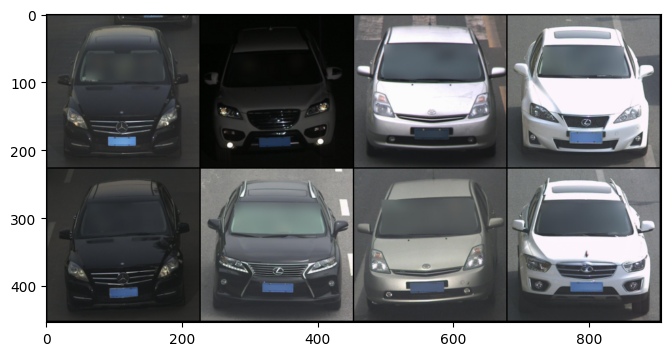

In [ ]:
example_batch = next(iter(train_dl))

n = 4

concatenated = torch.cat((example_batch[0][:n], example_batch[1][:n]),0)
grid_img = torchvision.utils.make_grid(concatenated, nrow=n)

fig, ax = plt.subplots(figsize=(36, 4))
ax.imshow(grid_img.permute(1, 2, 0), interpolation='bilinear')

print(example_batch[2].numpy().reshape(-1)[:n])

### Loss function

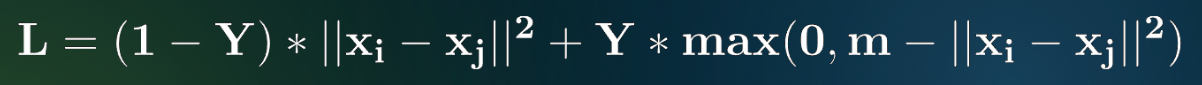

In [ ]:
# The loss function is sensitive to a batch size
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the Euclidean distance
        dist = F.pairwise_distance(output1, output2, keepdim=True)

        loss_contrastive = torch.mean((1-label)*torch.pow(dist, 2) + label*torch.clamp(self.margin - torch.pow(dist, 2), min=0)) # YOUR CODE HERE


        return loss_contrastive

In [ ]:
# test
c_loss = ContrastiveLoss(margin=2.0)
assert(8 - c_loss(torch.tensor([0,0,0,0,0,0,0,0]), torch.tensor([1,1,1,1,1,1,1,1]), 0).item() < 0.0001)

### The model in form of ```pytorch_lightning.LightningModule``` class.

In [ ]:
class SiameseNetwork(pl.LightningModule):
    def __init__(self, criterion, embeddingNet):
        super().__init__()
        self.save_hyperparameters(logger=False)

        self.criterion = criterion
        self.all_embs = []
        self.all_lbls = []

        self.embeddingNet = embeddingNet

    def forward_once(self, x):
        return self.embeddingNet.forward(x)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def training_step(self, batch, batch_idx):
        im1, im2, label = batch
        out1, out2 = self.forward(im1, im2)
        loss = self.criterion(out1, out2, label)
        return loss

    def validation_step(self, batch, batch_idx):
        self._collect_embeddings(batch, batch_idx)

    def on_validation_epoch_end(self):
        dist_ratio = self._calculate_map('val')
        self.all_embs = []
        self.all_lbls = []
        return dist_ratio

    def test_step(self, batch, batch_idx):
        self._collect_embeddings(batch, batch_idx)

    def on_test_epoch_end(self):
        dist_ratio = self._calculate_map('test')
        self.all_embs = []
        self.all_lbls = []
        return dist_ratio

    def _collect_embeddings(self, batch, batch_idx):
        # collect all embeddings and related labels for the batch on a validation step
        self.embeddingNet.eval()
        with torch.no_grad():
            imgs, lbls = batch
            embs = self.forward_once(imgs.to(device)).detach().cpu().numpy()
            self.all_embs += [e for e in embs]
            self.all_lbls += lbls

    def _calculate_map(self, step_label):
        # when validation is over, calculate mAP metrics for the collected embeddings
        aps = []
        for lbl_idx in range(len(self.all_lbls)):
            all_embs_tmp = self.all_embs.copy()
            all_lbls_tmp = self.all_lbls.copy()
            ancor_emb = all_embs_tmp.pop(lbl_idx)
            ancor_lbl = all_lbls_tmp.pop(lbl_idx)
            distances = np.linalg.norm(np.array(all_embs_tmp) - ancor_emb, axis=1)
            distances, all_lbls_tmp = (list(t) for t in zip(*sorted(zip(distances, all_lbls_tmp))))
            found_cnt = 0
            ap = 0
            for i, lbl in enumerate(all_lbls_tmp):
                if lbl == ancor_lbl:
                    found_cnt += 1
                    ap += found_cnt / (i+1)
            ap /= found_cnt
            aps.append(ap)

        mAP = sum(aps)/len(aps)
        self.log(f'{step_label}_map', mAP)
        return mAP

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.embeddingNet.parameters(), lr=1e-3)
        return optimizer

Initialize the model and the loss function:

In [ ]:
criterion = ContrastiveLoss(margin=2.0)
lit_model = SiameseNetwork(criterion, rn_model)

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_zero_warn(
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'embeddingNet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['embeddingNet'])`.
  rank_zero_warn(


Check, that the pl-model has the same parameters as the network for getting embeddings:

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
count_parameters(lit_model) == count_parameters(lit_model.embeddingNet)

True

Callback helps to keep the best checkpoint.

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

# callback for the best checkpoint saving
checkpoint_callback = ModelCheckpoint(dirpath='/content/drive/MyDrive/VideoAnalytics/lightning_checkpoints', mode='max', save_top_k=1, monitor="val_map")

### Training

In [ ]:
trainer = pl.Trainer(accelerator=device.type, max_epochs=50, callbacks=[checkpoint_callback])
trainer.fit(lit_model, train_dataloaders=train_dl, val_dataloaders=test_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /content/drive/MyDrive/VideoAnalytics/lightning_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type            | Params
-------------------------------------------------
0 | criterion    | ContrastiveLoss | 0     
1 | embeddingNet | ResNet          | 11.4 M
-------------------------------------------------
11.4 M    Trainable param

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


## Analysis of the result

Let's upload the best checkpoint of the model for the analysis:

In [ ]:
lit_model = SiameseNetwork.load_from_checkpoint('/content/drive/MyDrive/VideoAnalytics/lightning_checkpoints/epoch=39-step=11280.ckpt')

Collect embeddings for the training set:

In [ ]:
embeddings_train = []
labels_train = []
lit_model.to(device)
lit_model.eval()
with torch.no_grad():
    for im_n, cl in images_classes_train:
        im = Image.open(os.path.join(images_dir, im_n))
        x = test_transforms(im).unsqueeze(0).to(device)
        embeddings_train.append(lit_model.forward_once(x).detach().cpu().numpy()[0])
        labels_train.append(cl)

In [ ]:
embeddings_train[0][0:5]

array([ 4.4501867 , -0.21092525, -0.23673998, -1.7410301 ,  4.6672397 ],
      dtype=float32)

Decrease its demensionality using t-SNE:

In [ ]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(np.array(embeddings_train))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1130 samples in 0.001s...
[t-SNE] Computed neighbors for 1130 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1130
[t-SNE] Computed conditional probabilities for sample 1130 / 1130
[t-SNE] Mean sigma: 0.142857
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.572285
[t-SNE] KL divergence after 1000 iterations: 0.722238


Visualize the result:

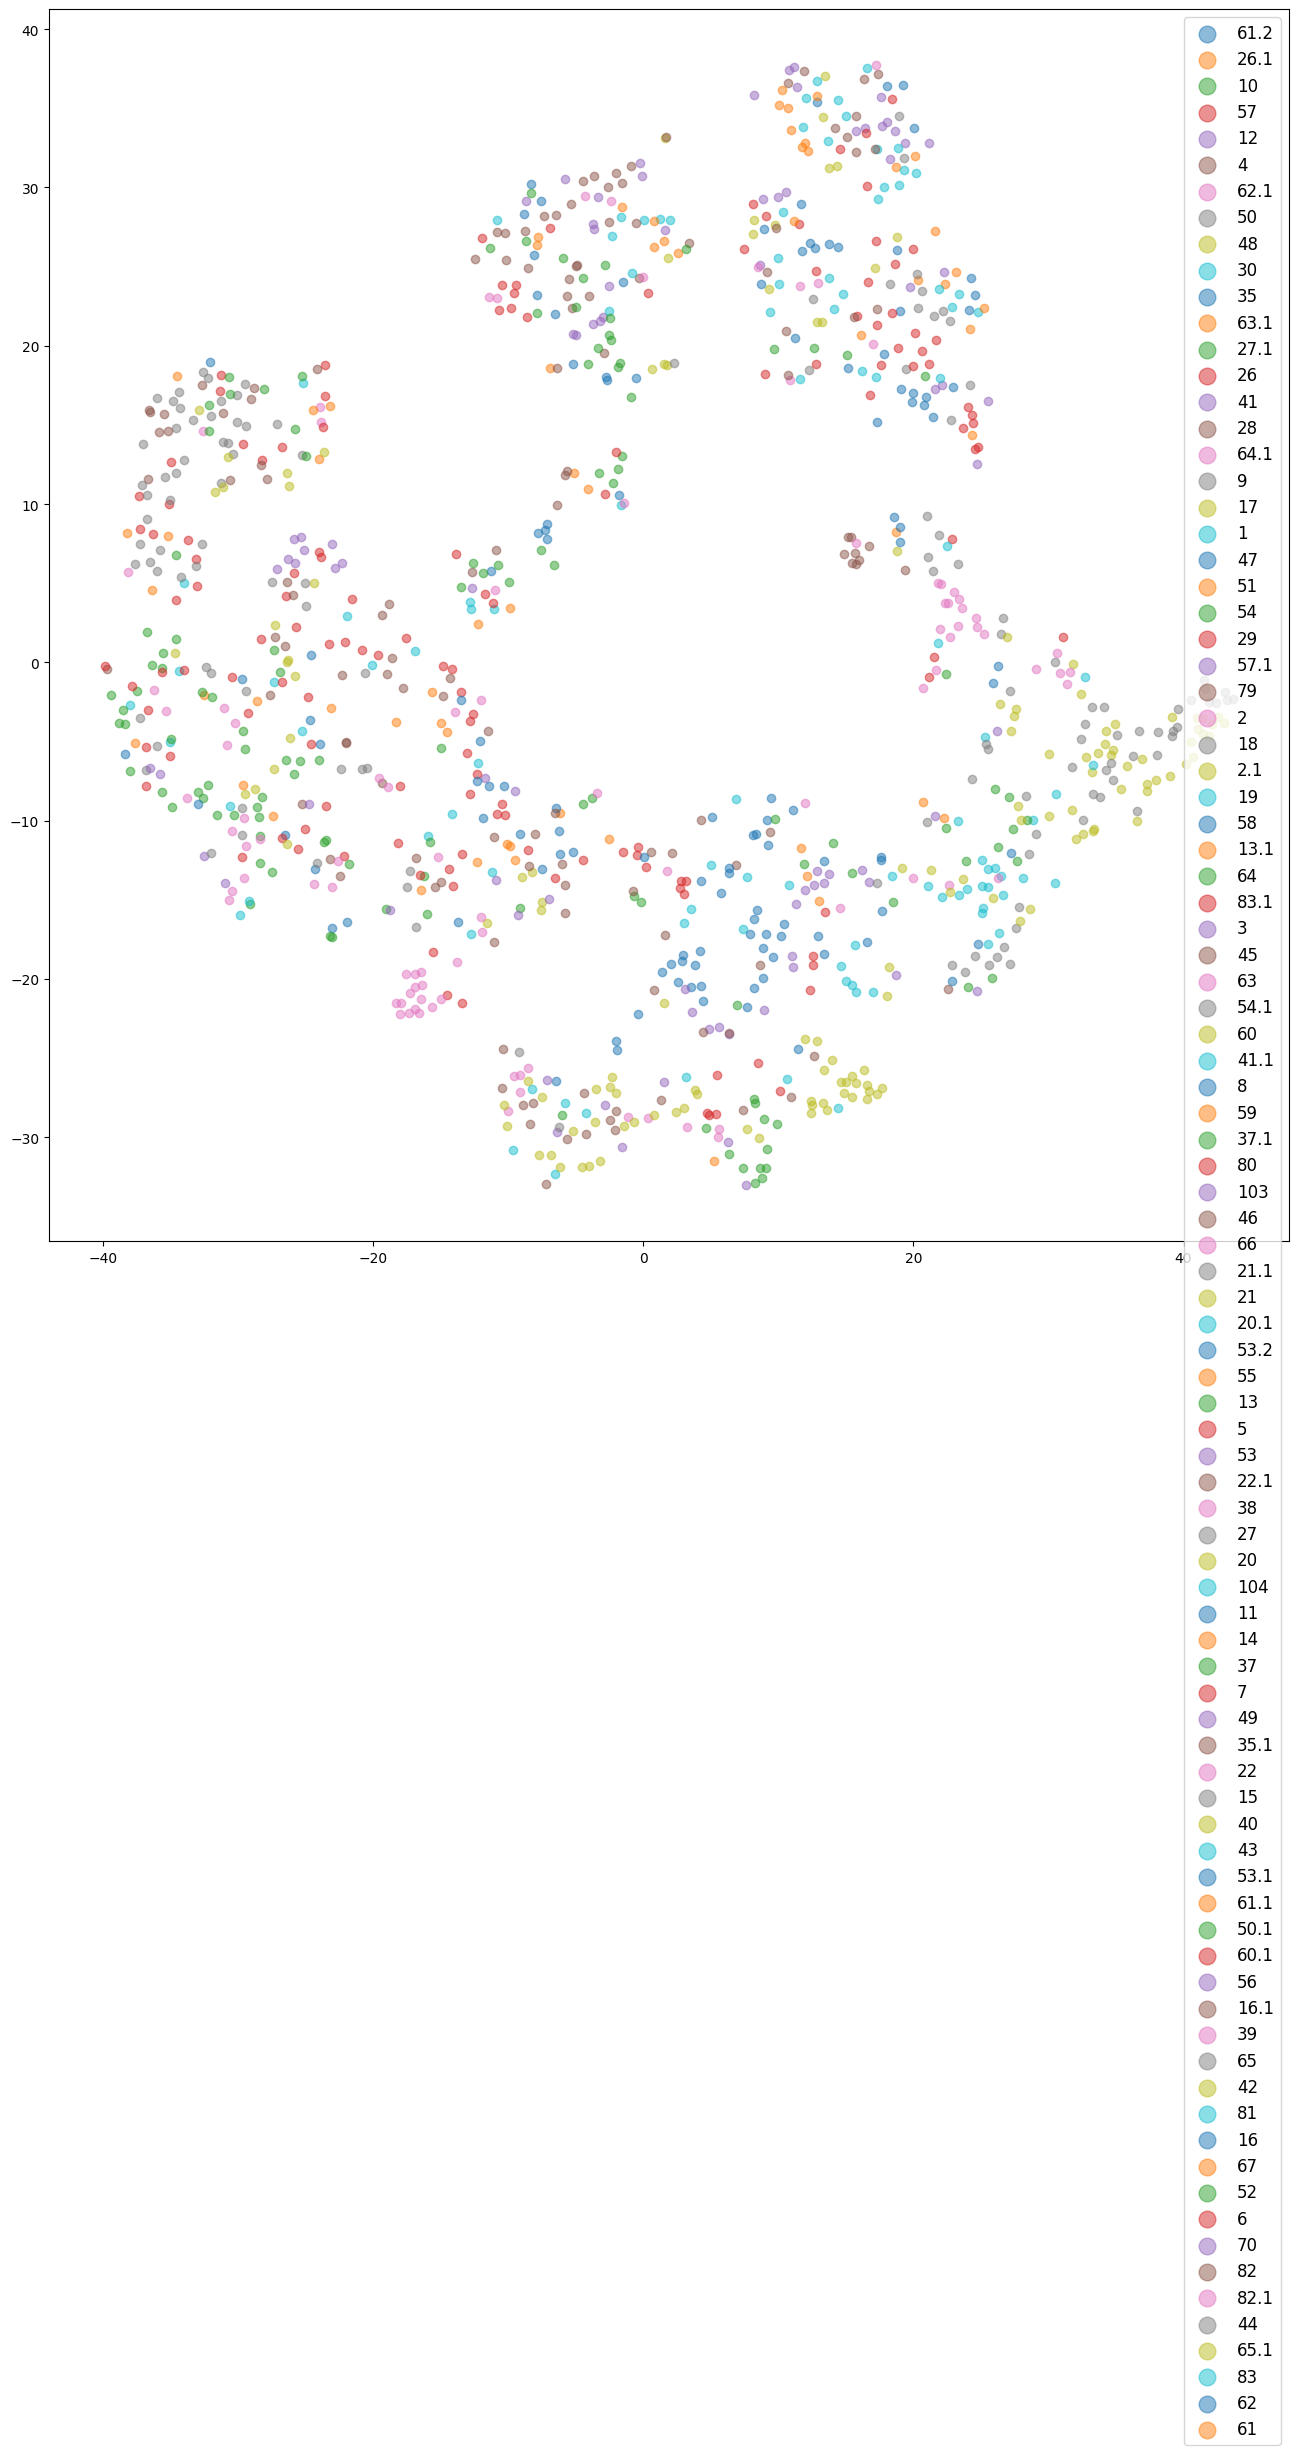

In [ ]:
fig, ax = plt.subplots(figsize=(16,16))
cat_set = list(set(labels_train))
num_categories = len(cat_set)
for i, lab in enumerate(range(num_categories)):
    indices = np.array(labels_train)==cat_set[lab]
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = cat_set[i] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

The same thing for the test dataset:

In [ ]:
embeddings_test = []
labels_test = []
lit_model.to(device)
lit_model.eval()

images_classes_test, _ = get_images_classes(images_dir_test)

with torch.no_grad():
    for im_n, cl in images_classes_test:
        im = Image.open(os.path.join(images_dir_test, im_n))
        x = test_transforms(im).unsqueeze(0).to(device)
        embeddings_test.append(lit_model.forward_once(x).detach().cpu().numpy()[0])
        labels_test.append(cl)

In [ ]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(np.array(embeddings_test))

[t-SNE] Computing 56 nearest neighbors...
[t-SNE] Indexed 57 samples in 0.001s...
[t-SNE] Computed neighbors for 57 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 57 / 57
[t-SNE] Mean sigma: 0.581773
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.687256
[t-SNE] KL divergence after 700 iterations: 0.065750


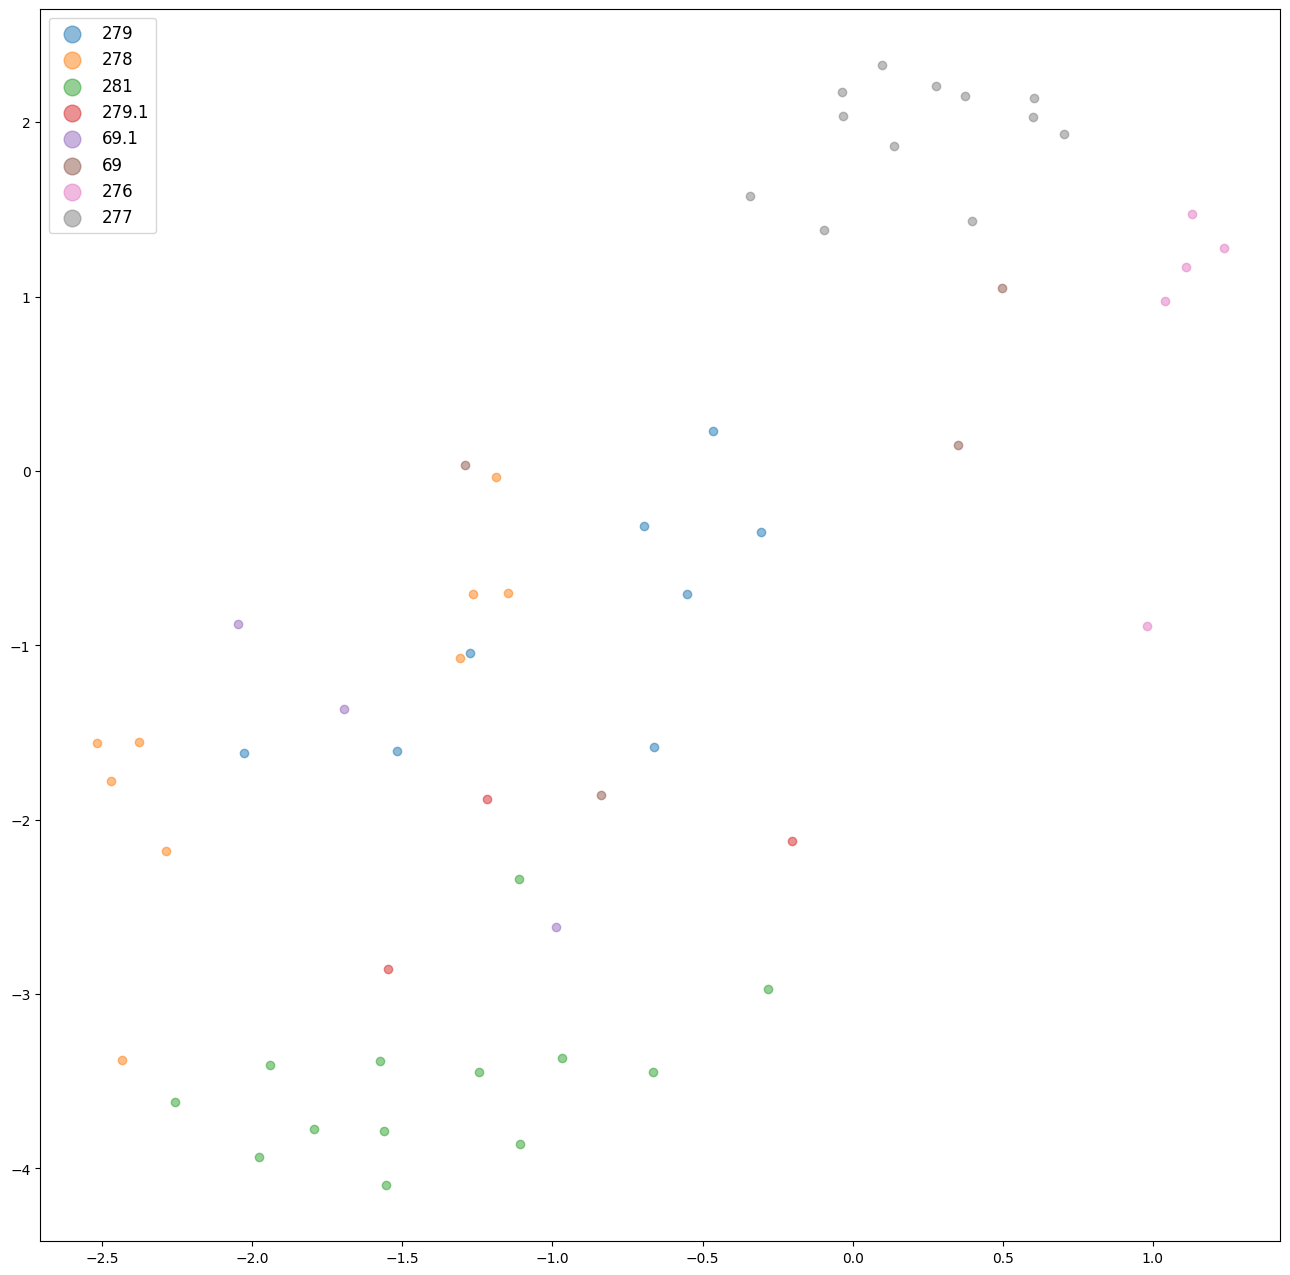

In [ ]:
fig, ax = plt.subplots(figsize=(16,16))
cat_set = list(set(labels_test))
num_categories = len(cat_set)
for i, lab in enumerate(range(num_categories)):
    indices = np.array(labels_test)==cat_set[lab]
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = cat_set[i] ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

The following code helps to compare embeddings of a random car from the dataset with embeddings of the same car.

In [ ]:
def get_random_triple_metrics(model, dataset_dir, transforms):
    model.to(device)
    model.eval()

    with torch.no_grad():
        images_classes_test, class_matching_test = get_images_classes(dataset_dir)

        classes_images_test = defaultdict(list)
        for im, cl in images_classes_test:
            classes_images_test[cl].append(im)

        cl1, cl2 = random.sample(classes_images_test.keys(), 2)

        im_pth_ancor, im_pth_pos = random.sample(classes_images_test[cl1], 2)
        im_pth_neg = random.choice(classes_images_test[cl2])

        im_ancor = Image.open(os.path.join(dataset_dir, im_pth_ancor))
        im_pos = Image.open(os.path.join(dataset_dir, im_pth_pos))
        im_neg = Image.open(os.path.join(dataset_dir, im_pth_neg))


        x = torch.stack([test_transforms(im_ancor), test_transforms(im_pos), test_transforms(im_neg)]).to(device)

        em_ancor, em_pos, em_neg = model(x).detach().cpu().numpy()

        distance_pos = np.linalg.norm(em_ancor - em_pos, axis=0)
        distance_neg = np.linalg.norm(em_ancor - em_neg, axis=0)
        return x.detach().cpu(), (cl1, cl2), (distance_pos, distance_neg)

<ipython-input-62-246852b5616e>:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  cl1, cl2 = random.sample(classes_images_test.keys(), 2)


276 69
0.93973017 1.4417111


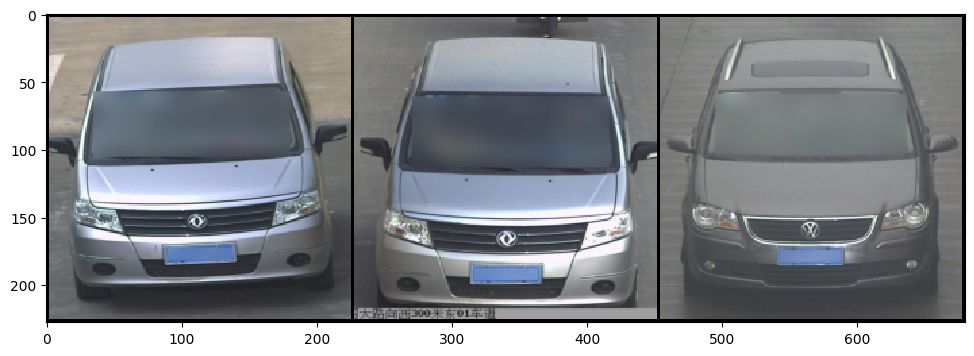

In [ ]:
x, (cl1, cl2), (d1, d2) = get_random_triple_metrics(rn_model, images_dir_test, test_transforms)

grid_img = torchvision.utils.make_grid(x)

fig, ax = plt.subplots(figsize=(36, 4))
ax.imshow(grid_img.permute(1, 2, 0), interpolation='nearest')
print(cl1, cl2)
print(d1, d2)

It seems that the model works rather well.